# 03: ANN for Classification

### 🎯 Objective
This notebook implements a simple ANN to solve a **binary classification** problem. We will create two distinct clusters of data and train a model to find the boundary that separates them.

### 📚 Key Concepts
- **Classification:** Predicting a category (e.g., "Class 0" vs. "Class 1") instead of a number.
- **Synthetic Data:** Generating 2D data clusters.
- **Sigmoid Function:** Using `nn.Sigmoid` as the final activation to get probability-like outputs (0 to 1).
- **BCELoss:** Using Binary Cross-Entropy as the loss function, which is designed for classification.
- **Accuracy:** Calculating the model's performance as a percentage.

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

## 1. Create the Data

Instead of a linear $y=x$ relationship, we will create two distinct "blobs" or "clusters" of data in a 2D plane. 

- **Class 0 (Blue Squares):** A cluster of 100 points centered at coordinates $[1, 1]$.
- **Class 1 (Black Circles):** A cluster of 100 points centered at coordinates $[5, 1]$.

The `blur` variable controls how spread out and overlapping these clusters are. The model's job is not to predict a continuous value, but to draw a line (a **decision boundary**) that best separates these two groups.



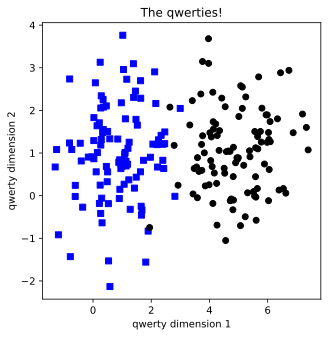

In [2]:
# create data

nPerClust = 100 # Number of points in each cluster
blur = 1        # Standard deviation of the noise (controls spread)

# Centers for the two clusters
A = [  1, 1 ]
B = [  5, 1 ]

# generate data points for cluster 'a' (class 0)
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]

# generate data points for cluster 'b' (class 1)
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]

# true labels
# Stack 100 0s (for class 'a') on top of 100 1s (for class 'b')
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate data into a matrix
# .T transposes the data so that it's in the shape (samples, features) -> (200, 2)
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
# Plot class 0: data[where labels==0, column 0], data[where labels==0, column 1]
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
# Plot class 1: data[where labels==1, column 0], data[where labels==1, column 1]
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## 2. Inspect Data Types and Shape

This is a quick sanity check to confirm our data is in the shape our model will expect.
We have 200 samples, and 2 features per sample (dim 1, dim 2). 
Therefore, our model's input layer must accept **2 features**.

In [3]:
# inspect types
print(type(data_np))
print(np.shape(data_np)) # Shape: (200, 2)
print(' ')

print(type(data))
print(np.shape(data)) # Shape: torch.Size([200, 2])

<class 'numpy.ndarray'>
(200, 2)
 
<class 'torch.Tensor'>
torch.Size([200, 2])


## 3. Build the Model

This architecture is slightly different from the regression model, specifically in the input and output layers.

1.  **`nn.Linear(2,1)`**: Input layer. It takes **2** input features and maps them to 1 hidden neuron.
2.  **`nn.ReLU()`**: Standard activation function.
3.  **`nn.Linear(1,1)`**: Output layer. Takes the 1 neuron from the previous layer and maps it to 1 final output neuron.
4.  **`nn.Sigmoid()`**: This is the crucial part for classification. It squashes the output of the final neuron into a range between 0 and 1, which we can interpret as the *probability* of the data point belonging to Class 1.

**Note:** As the code comment says, including `nn.Sigmoid()` here works *only* because we are using `nn.BCELoss`. A more modern and numerically stable approach is to *remove* the `nn.Sigmoid()` layer and use `nn.BCEWithLogitsLoss()` as the loss function, which has the sigmoid built-in.

In [4]:
# build the model
ANNclassify = nn.Sequential(
    nn.Linear(2,1),   # input layer (2 features -> 1 neuron)
    nn.ReLU(),        # activation unit
    nn.Linear(1,1),   # output unit (1 neuron -> 1 output)
    nn.Sigmoid(),     # final activation unit (squashes output to 0-1)
      )

print(ANNclassify)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)


## 4. Define Loss Function and Optimizer

1.  **Loss Function:** `nn.BCELoss()` (Binary Cross-Entropy Loss). This is the standard loss function for binary (two-class) classification. It measures how far the model's predicted probabilities (e.g., 0.9) are from the true binary labels (e.g., 1.0). It's much more effective for this than MSE.

2.  **Optimizer:** `torch.optim.SGD`. Same as before, this is the algorithm that will update our weights.

In [5]:
# other model features

learningRate = .01

# loss function
lossfun = nn.BCELoss()
# Note: You'll learn in the "Metaparameters" section that it's better to use BCEWithLogitsLoss, but this is OK for now.

# optimizer
optimizer = torch.optim.SGD(ANNclassify.parameters(),lr=learningRate)


## 5. Train the Model

The training loop is **identical** to the one used for regression. This is the power of PyTorch. By defining a new `model` and a new `lossfun`, the *process* of training remains the same.

1.  **Forward Pass:** Get model's probability outputs (`yHat`).
2.  **Compute Loss:** Calculate the BCELoss between `yHat` (probabilities) and `labels` (true 0s and 1s).
3.  **Backpropagation:** Calculate gradients.
4.  **Optimizer Step:** Update weights.

In [6]:
# train the model
numepochs = 1000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

  # 1. forward pass
  yHat = ANNclassify(data)

  # 2. compute loss
  loss = lossfun(yHat,labels)
  losses[epochi] = loss

  # 3. backprop
  optimizer.zero_grad()
  loss.backward()

  # 4. optimizer step
  optimizer.step()

In [7]:
# Show the final loss value
losses[-1]

tensor(0.4969, grad_fn=<SelectBackward0>)

## 6. Visualize the Loss

We plot the loss over epochs to confirm that the model learned. We expect a steep drop followed by a plateau at a low value.

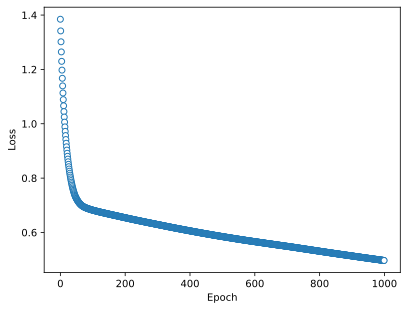

In [8]:
# show the losses

plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 7. Compute Model Accuracy

Loss is what the model optimizes, but **accuracy** is what we humans care about. 

To get accuracy, we perform two steps:
1.  **Get Predictions:** Get the model's final probability outputs (e.g., `[0.1, 0.9, 0.4, ...]`).
2.  **Apply a Threshold:** Convert these probabilities into firm decisions. The standard threshold is 0.5. 
    - If `prediction > 0.5`, we label it **Class 1**.
    - If `prediction <= 0.5`, we label it **Class 0**.

We then compare these `predlabels` to the true `labels` to find the total accuracy.

In [9]:
# compute the predictions

# final forward pass to get probabilities
predictions = ANNclassify(data)

# Apply threshold to get predicted class labels (0 or 1)
predlabels = predictions>.5

# find the indices where the predicted label does not equal the true label
misclassified = np.where(predlabels != labels)[0]

# total accuracy
# (100 * number of wrong answers) / total number of items
totalacc = 100-100*len(misclassified)/(2*nPerClust)

print('Final accuracy: %g%%' %totalacc)


Final accuracy: 82.5%


## 8. Visualize the Final Results

This final plot shows us *how* the model made its decisions.

- **Blue Squares (`bs`):** All data points the model *predicted* as Class 0.
- **Black Circles (`ko`):** All data points the model *predicted* as Class 1.
- **Red X's (`rx`):** Any data point that was misclassified. 

In a good run, the black and blue points will be well-separated, and there will be very few (or no) red X's.

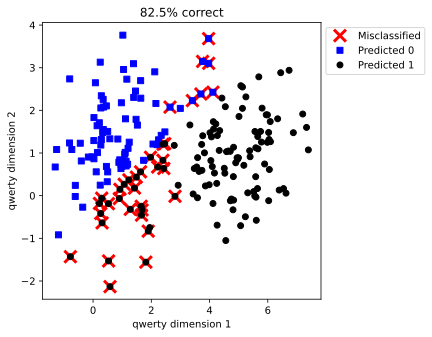

In [10]:
# plot the labeled data
fig = plt.figure(figsize=(5,5))

# Plot misclassified points as red X's
plt.plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=12,markeredgewidth=3)

# Plot all points predicted as class 0 (blue squares)
# Note: ~predlabels inverts the boolean, so this is np.where(predlabels==False)
plt.plot(data[np.where(~predlabels)[0],0],data[np.where(~predlabels)[0],1],'bs')

# Plot all points predicted as class 1 (black circles)
plt.plot(data[np.where(predlabels)[0],0] ,data[np.where(predlabels)[0],1] ,'ko')

plt.legend(['Misclassified','Predicted 0','Predicted 1'],bbox_to_anchor=(1,1))
plt.title(f'{totalacc}% correct')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## 9. Additional Explorations

In [ ]:
# 1) It is common in DL to train the model for a specified number of epochs. But you can also train until
#    the model reaches a certain accuracy criterion. Re-write the code so that the model continues training
#    until it reaches 90% accuracy.
#    What would happen if the model falls into a local minimum and never reaches 90% accuracy? Yikes! You can
#    force-quit a process in google-colab by clicking on the top-left 'play' button of a code cell.
#
# 2) It is intuitive that the model can reach 100% accuracy if the qwerties are more separable. Modify the
#    qwerty-generating code to get the model to have 100% classification accuracy.